Load Data Profile

Add Volume Profile



c:\Users\nerea\anaconda3\envs\SCenv\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


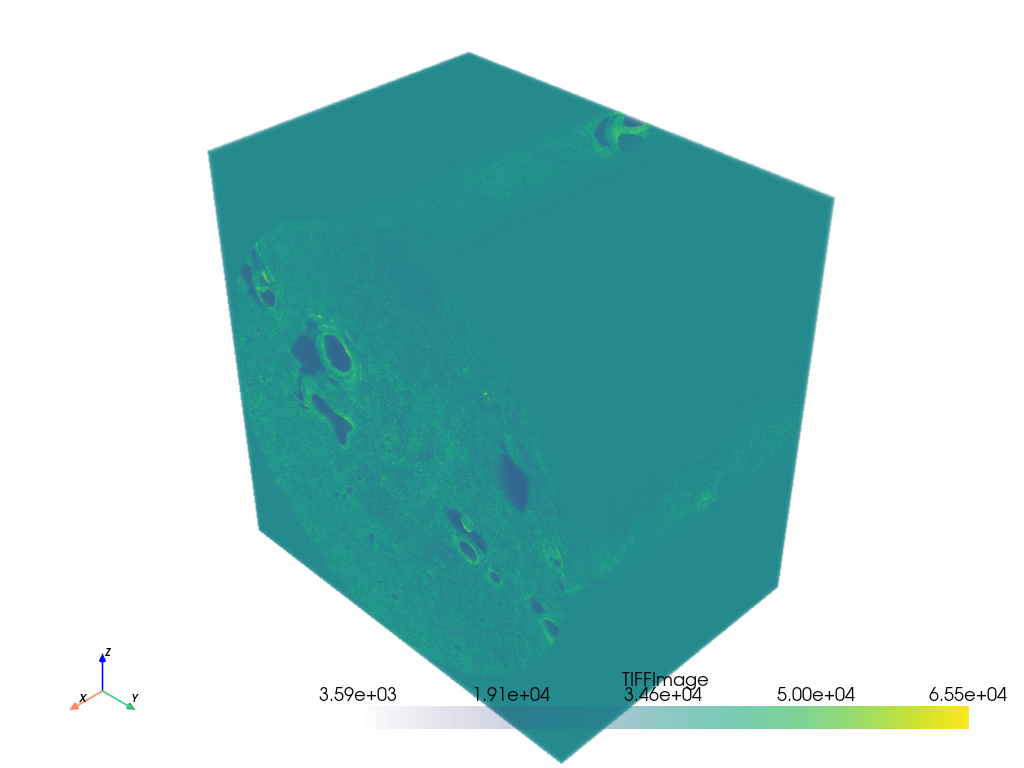

In [9]:
import os
import numpy as np
import tifffile as tiff
import pyvista as pv
import scipy.ndimage

def load_data(tiff_directory):
    # Read all TIFF files and stack them into a 3D volume
    tiff_files = sorted([f for f in os.listdir(tiff_directory) if f.endswith('.tif')])
    volume_data = np.array([tiff.imread(os.path.join(tiff_directory, f)) for f in tiff_files])

    downscale_factors = (0.2, 0.2, 0.2)  # Example: downscale by 50% in each dimension
    downscaled_volume = scipy.ndimage.zoom(volume_data, downscale_factors, order=1)

    del volume_data, tiff_files  # Free up memory

    # Create a PyVista UniformGrid
    volume = pv.ImageData()
    volume.dimensions = downscaled_volume.shape
    volume["TIFFImage"] = downscaled_volume.flatten(order="F")  # Flatten in Fortran order

    volume.spacing = (1, 1, 1)  # Set spacing; adjust as needed

    return volume

if __name__ == "__main__":
    folder = 'data/images'  # Specify the directory containing the TIFF files

    print("Load Data Profile")
    print("=================")

    volume = load_data(folder)

    print()

    p = pv.Plotter()

    print("Add Volume Profile")
    print("==================")

    p.add_volume(
        volume,
        blending="composite",
        scalars="TIFFImage",
        reset_camera=True,
    )

    print()

    p.add_axes()

    p.show()

In [ ]:
import os
import numpy as np
import tifffile as tiff
from scipy.ndimage import zoom

# Specify the directory containing the TIFF files
tiff_directory = 'data/images'

# Read all TIFF files and stack them into a 3D volume
tiff_files = sorted([f for f in os.listdir(tiff_directory) if f.endswith('.tif')])
volume = np.array([tiff.imread(os.path.join(tiff_directory, f)) for f in tiff_files])

# Print the shape of the volume before downscaling
print("Original Volume shape:", volume.shape)

# Define downscale factors for each dimension (z, y, x)
downscale_factors = (0.2, 0.2, 0.2)  # Example: downscale by 50% in each dimension

# Downscale the volume using scipy.ndimage.zoom
downscaled_volume = zoom(volume, downscale_factors, order=1)  # order=1 is bilinear interpolation

del volume

# Print the shape of the volume after downscaling
print("Downscaled Volume shape:", downscaled_volume.shape)


In [5]:
del downscaled_volume

In [7]:
import plotly.graph_objects as go
import numpy as np

# Assuming downscaled_volume is a 3D numpy array
x, y, z = np.indices(downscaled_volume.shape)

# Create a 3D scatter plot
fig = go.Figure(data=go.Volume(
    x=x.flatten(),
    y=y.flatten(),
    z=z.flatten(),
    value=downscaled_volume.flatten(),
    isomin=downscaled_volume.min(),
    isomax=downscaled_volume.max(),
    opacity=0.1,  # Adjust opacity for better visualization
    surface_count=10,  # Number of isosurfaces
))

fig.update_layout(scene=dict(
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Z'
))

fig.show()

In [ ]:
import numpy as np
import pyvista as pv
from vtk import vtkImageData
import vtkmodules.util.numpy_support

# Assume `binary_volume` is already defined (from previous code)
# binary_volume should be a 3D numpy array

# Get the dimensions of the volume
dims = downscaled_volume.shape

# Create a VTK ImageData object
imageData = vtkImageData()
imageData.SetDimensions(dims[2], dims[1], dims[0])  # Note: dimensions are in (x, y, z) order

# Set the voxel values (scalar data)
flat_volume = downscaled_volume.flatten(order='F')  # Flatten in Fortran order (z,y,x)
vtk_array = vtkmodules.util.numpy_support.numpy_to_vtk(flat_volume)  # Convert numpy array to VTK array
imageData.GetPointData().SetScalars(vtk_array)

# Create a pyvista object from the VTK image data
grid = pv.wrap(imageData)

# Save the 3D volume as a .vti file
output_file = "downscaled_volume.vti"
grid.save(output_file)

print(f"Volume saved as {output_file}")


In [2]:
from skimage.filters import threshold_otsu

# Calculate the global threshold using Otsu's method
threshold_value = threshold_otsu(downscaled_volume)

# Binarize the volume using the calculated threshold
binary_volume = (downscaled_volume > threshold_value).astype(np.uint8)

In [ ]:
import numpy as np
import pyvista as pv
from vtk import vtkImageData
import vtkmodules.util.numpy_support

# Assume `binary_volume` is already defined (from previous code)
# binary_volume should be a 3D numpy array

# Get the dimensions of the volume
dims = binary_volume.shape

# Create a VTK ImageData object
imageData = vtkImageData()
imageData.SetDimensions(dims[2], dims[1], dims[0])  # Note: dimensions are in (x, y, z) order

# Set the voxel values (scalar data)
flat_volume = binary_volume.flatten(order='F')  # Flatten in Fortran order (z,y,x)
vtk_array = vtkmodules.util.numpy_support.numpy_to_vtk(flat_volume)  # Convert numpy array to VTK array
imageData.GetPointData().SetScalars(vtk_array)

# Create a pyvista object from the VTK image data
grid = pv.wrap(imageData)

# Save the 3D volume as a .vti file
output_file = "binarized_volume.vti"
grid.save(output_file)

print(f"Volume saved as {output_file}")


In [ ]:
import plotly.graph_objects as go
import numpy as np

# Assume `binary_volume` is already defined (from previous code)

# Create a 3D volume plot using Plotly
fig = go.Figure(data=go.Volume(
    x=np.linspace(0, binary_volume.shape[2], binary_volume.shape[2]),  # x-axis values
    y=np.linspace(0, binary_volume.shape[1], binary_volume.shape[1]),  # y-axis values
    z=np.linspace(0, binary_volume.shape[0], binary_volume.shape[0]),  # z-axis values
    value=binary_volume.flatten(),  # Flatten the 3D volume to 1D array for plotting
    opacity=0.1,  # Adjust the opacity to make the volume semi-transparent
    surface_count=15,  # Number of iso-surfaces for visualization (more for higher detail)
    colorscale='gray',  # Use grayscale color map
))

# Set titles and axis labels
fig.update_layout(
    title="3D Binarized Volume Visualization",
    scene=dict(
        xaxis_title='X axis',
        yaxis_title='Y axis',
        zaxis_title='Z axis'
    ),
)

# Show the interactive plot
fig.show()


In [1]:
import os
import numpy as np
from skimage import io as tiff
from skimage.morphology import skeletonize_3d
import matplotlib.pyplot as plt

# Specify the directory containing the TIFF files
tiff_directory = 'data/images'

# Read all TIFF files (you already have this part)
tiff_files = sorted([f for f in os.listdir(tiff_directory) if f.endswith('.tif')])

# Initialize an empty list to store processed slices
binary_volume = []

# Set a threshold value (manual or from Otsu's method)
threshold_value = 35000  # You can adjust this value

# Process each slice one by one to avoid memory issues
for file in tiff_files:
    slice = tiff.imread(os.path.join(tiff_directory, file))
    # Thresholding the slice
    binary_slice = (slice > threshold_value).astype(np.uint8)
    # Append the binary slice to the list
    binary_volume.append(binary_slice)

# Convert list of slices to 3D numpy array
binary_volume = np.array(binary_volume)



In [4]:
del binary_slice, slice, file, tiff_files, tiff_directory, threshold_value

In [ ]:
import plotly.graph_objects as go
import numpy as np


fig = go.Figure(data=go.Volume(
    x=np.arange(binary_volume.shape[0]).repeat(binary_volume.shape[1] * binary_volume.shape[2]),
    y=np.tile(np.arange(binary_volume.shape[1]).repeat(binary_volume.shape[2]), binary_volume.shape[0]),
    z=np.tile(np.arange(binary_volume.shape[2]), binary_volume.shape[0] * binary_volume.shape[1]),
    value=binary_volume.flatten(),
    isomin=0,
    isomax=1,
    opacity=0.1,  # needs to be small to see through all surfaces
    surface_count=17,  # needs to be a large number for good volume rendering
))

fig.show()

In [ ]:
import skimage
# Now you can skeletonize or process the binary volume
skeleton = skimage.morphology.skeletonize(binary_volume)

print("Skeletonization completed!")

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tifffile as tiff
import os

In [1]:
for var in dir():
    if var[0] != '_':
        del globals()[var]

In [ ]:
# Specify the directory containing the TIFF files
tiff_directory = 'data/images'

# Read all TIFF files and stack them into a 3D volume
tiff_files = sorted([f for f in os.listdir(tiff_directory) if f.endswith('.tif')])
volume = np.array([tiff.imread(os.path.join(tiff_directory, f)) for f in tiff_files])

# Print the shape of the volume
print("Volume shape:", volume.shape)


In [3]:
del tiff_directory, tiff_files, os

In [ ]:
import matplotlib.pyplot as plt

# Plot histogram of volume intensities
plt.hist(volume.ravel(), bins=256)
plt.title("Intensity Histogram")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# Binarize the volume using the computed threshold
binary_volume = (volume > 35000).astype(np.uint8)

In [8]:
del volume

In [ ]:
import os
import numpy as np
from skimage import io as tiff
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt

# Skeletonize the 3D volume
skeleton = skeletonize(volume)

# Print the shape of the skeletonized volume
print("Skeleton shape:", skeleton.shape)

# Function to visualize slices from the original and skeletonized volume
def show_slices(slices, title=""):
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice, cmap="gray")
        axes[i].set_title(f'Slice {i}')
    fig.suptitle(title)
    plt.show()

# Visualize a middle slice from the original and skeletonized volume
mid_slice_original = volume[volume.shape[0] // 2, :, :]
mid_slice_skeleton = skeleton[skeleton.shape[0] // 2, :, :]

show_slices([mid_slice_original, mid_slice_skeleton], title="Original vs Skeleton (Middle Slice)")
